Alumno: Zhengkai Zhu


# Estimacion de Fase cuántica (Quantum Phase Estimation)

In [ ]:
!pip install -U qiskit-aer
!pip install -U pylatexenc
!pip install -U qiskit-ibm-runtime
!pip install -U --no-cache-dir qiskit

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import warnings
warnings.filterwarnings("ignore")
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator

La estimación de fase cuántica es una de las subrutinas fundamentales en computación cuántica, desempeñando un papel central en numerosos algoritmos cuánticos. Su propósito principal es determinar con alta precisión la fase asociada a un autovalor de una operación cuántica dada:

> Dado un operador unitario $U$, el algoritmo estima el parámetro $\theta$ en la ecuación $U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$, donde $|\psi\rangle$ es un autovector y $e^{\boldsymbol{2\pi i}\theta}$ es el autovalor correspondiente. Debido a la unitariedad de $U$, todos sus autovalores tienen módulo igual a 1.
Realizaremos varios ejercicios para construir el circuito de este algoritmo y estimar las fases de distintos operadores. Primero, importamos las bibliotecas necesarias.


In [4]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
##from qiskit import Aer, transpile, assemble
##from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools
##from qiskit.visualization import plot_histogram

Y una funcion para visualizar los resultados de las medidas:

In [5]:
def count_to_digital_values(counts):
    counts_ordenado=sorted(counts)
    print('resultado -- cuenta')
    for k in counts_ordenado:
        print(k, '     --',counts[k])

## Introducción

A continuación se muestra el circuito cuántico general para la estimación de fase.

El registro inferior es un registro auxiliar que llamaremos **registro contador o de conteo** y contiene $m$ qubits y el superior contiene $n$ qubits en el estado $|\psi\rangle$:

![image1](QPE1.png)



El algoritmo de estimación de fase cuántica emplea el **retroceso de fase** (*phase kick-back*) para codificar la fase de $U$ en la base de Fourier dentro de los $m$ qubits del registro de conteo. Posteriormente, se aplica la **Transformada Cuántica de Fourier inversa (QFT inversa)** para convertir esta información de la base de Fourier a la base computacional, permitiendo así su medición.



Cuando usamos un autovector para controlar la puerta $U$ sobre un qubit, el qubit girará (debido al **retroceso de fase**) proporcionalmente a la fase $e^{2i\pi\theta}$. Podemos usar sucesivas puertas $CU$ para repetir esta rotación un número apropiado de veces hasta que hayamos codificado la fase $\theta$ como un número entre $0$ y $2^m$ en la base de Fourier.
Finalmente, aplicamos la $IQFT$ para transformar este estado a la base computacional, permitiendo su medición.




### Funcionamiento del circuito QPE

Como se mencionó anteriormente, este circuito estima la fase de un operador unitario $U$. Estima $\theta$ en $U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$, donde $|\psi\rangle$ es un vector propio y $ e^{\boldsymbol{2\pi i}\theta}$ es el valor propio correspondiente. El circuito opera en los siguientes pasos:

0. **Setup**: $\vert\psi\rangle$ está en un conjunto de registros de qubit. Un conjunto adicional de $m$ qubits forma el registro de conteo en el que almacenaremos el valor $2^n\theta$:



$$ |\psi_0\rangle = \lvert 0 \rangle^{\otimes m}  \otimes \lvert \psi \rangle $$



1. **Superposición**: Aplicamos una operación de puerta Hadamard de $m$ bits $H^{\otimes m}$, en el registro de conteo:



$$ |\psi_1\rangle = {\frac {1}{\sqrt {2^m}}}\left(|0\rangle +|1\rangle \right)^{\otimes m} \otimes \lvert \psi \rangle $$



2. **Operaciones Unitarias Controladas**: Necesitamos introducir el operador $CU$ unitario de la $U$ controlada que aplica el operador unitario $U$ en el registro de destino solo si su bit de control correspondiente es $|1\rangle$.

Dado que $U$ es un operador unitario con vector propio $|\psi\rangle$ tal que $U|\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$, esto significa :

$$U^{2^{m}}|\psi \rangle =U^{2^{m-1}}U|\psi \rangle =U^{2^{m-1}}e^{2\pi i\theta }|\psi \rangle =\cdots =e^{2\pi i2^{m}\theta }|\psi \rangle$$


Aplicando todas las operaciones controladas $m$ $CU^{2^j}$ con $0\leq j\leq m-1$, y usando la relación $|0\rangle \otimes |\psi \rangle +|1\rangle \otimes e^{2\pi i\theta }|\psi \rangle =\left(|0\rangle +e^{2\pi i\theta }|1\rangle \right)\otimes |\psi \rangle$


\begin{aligned}
|\psi_{2}\rangle = \frac {1}{\sqrt{2^m}} \sum _{k=0}^{2^{m}-1}e^{\boldsymbol{2\pi i} \theta k}|k\rangle \otimes \lvert \psi \rangle = QFT \vert2^m\theta\rangle \otimes \lvert \psi \rangle  
\end{aligned}



\begin{aligned}
|\psi_{2}\rangle & =  \frac {1}{\sqrt{2^m}} [ \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{m-1}}}|1\rangle \right) \otimes \cdots \otimes \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{1}}}\vert1\rangle \right) \otimes \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{0}}}\vert1\rangle \right)] \otimes \lvert \psi \rangle = \frac {1}{\sqrt{2^m}} \sum _{k=0}^{2^{m}-1}e^{\boldsymbol{2\pi i} \theta k}|k\rangle \otimes \lvert \psi \rangle
\end{aligned}
donde $k$ denota la representación entera de números binarios de m bits.

iv. **Transformada de Fourier inversa**: Observamos que la expresión anterior es exactamente el resultado de aplicar una transformada cuántica de Fourier. Recordamos que la QFT asigna un estado de entrada de m-qubit $\vert j\rangle$ a una salida como

$$\vert j \rangle \mapsto \frac{1}{\sqrt{2^m}}\sum_{k=0}^{2^m-1}e^{2\pi i \frac{jk}{2^m}} \vert k \rangle$$

$$
QFT\vert j_{m-1}j_{m-2}...j_0 \rangle = \frac{1}{\sqrt{2^m}}
\left(\vert0\rangle + e^{\frac{2\pi i}{2}j} \vert1\rangle\right)
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^2}j} \vert1\rangle\right)
\otimes  
\ldots
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^{m-1}}j} \vert1\rangle\right)
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^m}j} \vert1\rangle\right)
$$

Reemplazar $j$ por $2^m\theta$ en la expresión anterior da exactamente la expresión derivada en el paso 2 anterior. Por lo tanto, para recuperar el estado $\vert2^m\theta\rangle$, apliquamos una transformada de Fourier inversa en el registro de conteo auxiliar. Al hacerlo, encontramos $(2^m \theta)$ en el registro de conteo.

3. **Medición**:
Al medir los $m$ qubits del registro contador encontraremos un máximo de resultados cerca de $j = 2^m\theta$. Para el caso en que $2^m\theta$ es un número entero, medir en la base computacional da la fase exacta en el registro auxiliar con alta probabilidad:

$$ |\psi_4\rangle = | 2^m \theta \rangle $$

Para el caso en el que $2^m\theta$ no sea un número entero, se puede demostrar que la expresión anterior todavía alcanza su punto máximo cerca de $j = 2^m\theta$ con una probabilidad mejor que $4/\pi^2 \approx 40\%$.

## QPE para la puerta T

Tomemos una puerta que conocemos bien, la puerta $T$, y usemos la estimación de fase cuántica para estimar su fase. Recordemos que la puerta $T$ agrega una fase de $e^\frac{i\pi}{4}$ al estado $|1\rangle$:

$$ T|1\rangle =
\begin{bmatrix}
1 & 0\\
0 & e^\frac{i\pi}{4}\\
\end{bmatrix}
\begin{bmatrix}
0\\
1\\
\end{bmatrix}
= e^\frac{i\pi}{4}|1\rangle $$

Dado que QPE nos dará el angulo $\theta$ que cumple:

$$ T|1\rangle = e^{2i\pi\theta}|1\rangle $$

De forma que esperamos encontrar:

$$\theta = \frac{1}{8}$$

Utilizaremos $m=3$ qubits en el registro contador para obtener **un resultado exacto**. Esto es asi porque en este caso $2^m \theta=1$ es un numero entero y vamos a poder medir con total certidumbre la fase(no una estimacion!).

### EJERCICIO

Crea el circuito cuantico de la QPE para el operador T.

*   En nuestro caso tenemos $n=1$ qubit del registro del vector propio del operador T que es |1> y tomaremos $m=3$ qubits para la resolucion de la medida de fase en el registro de conteo

*   Crea un circuito cuantico de $n+m$ qubits y $m$ bits clasicos para recoger la medida de la fase

*   Inicializa el primer qubit $q_0$ a $\vert\psi\rangle = \vert1\rangle$ aplicando una puerta $X$

*   El resto de qubits ponlos en superposicion con la puesta de Hadamard $H$

*   Aplica las puertas $CU$, control $U$, que seguiran el siguiente patron: $U$ para el $qn$, $U^2$ para $q_{n+1}$ ... y $U^{2^{m-1}}$ para $q_{n+m-1}$. Recuerda que $U^k$ es equivalente a aplicar la puerta $U$ $k$ veces.

* Dibuja el circuito



In [6]:
#Importo la puerta T de qiskit para poder convertirlo en una puerta controlada
from qiskit.circuit.library import TGate

In [7]:
n = 1
m = 3 

In [155]:
def apply_CU_gate(n, m, cu_gate, qc, barrier = True):
    for i in range(m - 1, -1, -1):
        if (barrier):
            qc.barrier()
        k = 2**i
        for j in range(k):
            qc.append(cu_gate, [i] + [t for t in range(m, m + n, 1)]) # i es el qubit de control y el resto son los objetivo
           

    return qc 

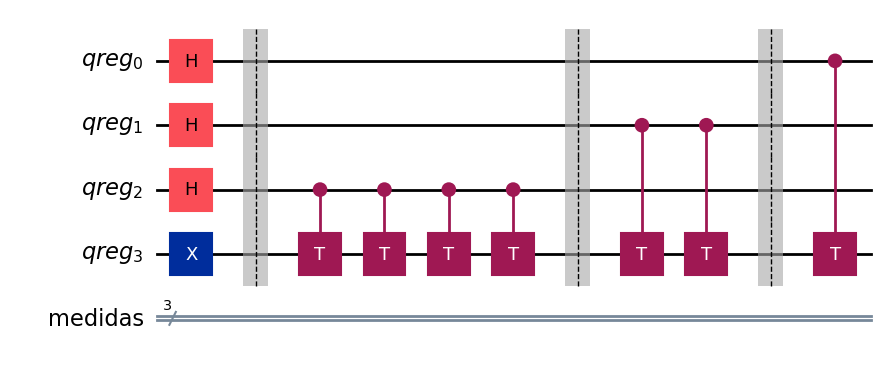

In [9]:
qreg = QuantumRegister(n + m, 'qreg')
creg = ClassicalRegister(m, 'medidas')

qc = QuantumCircuit(qreg, creg)


#Aplico una puerta X al qubit n + m - 1 que es el qubit que me servira de autovector o vector propio
qc.x(qreg[n + m - 1])

#Aplico la puerta H a todos los qubits de medida
qc.h(qreg[0:m])

#Ahora aplico aqui las puertas U controladas, donde U es la puerta T en este caso
ct = TGate().control(1)
qc = apply_CU_gate(n, m, ct, qc)



display(qc.draw('mpl'))


Ahora definimos la siguiente funcion que construye la QFT inversa para aplicarla a los $m$ ultimos qubits de un circuito de $n+m$ qubits:

Como en prácticas anteriores ya hemos implementado la QFT, en vez de copiar y pegar el código, voy a utilizar las puertar QFT e IQFT de la librería de Qiskit

In [10]:
from qiskit.circuit.library import QFT

In [11]:
def inverse_qft(m, qc):
    iqft = QFT(m, do_swaps = True, inverse=True)
    qc.append(iqft, range(m))
    
    return qc

Finalmente en nuestro de circuito de calculo de la QPE :

*   Ponemos una barrera
*   Añadimos el circuito de la QFT Inversa
*   Ponemos otra barrera y añadimos las puertas de medida
*   Dibujamos el circuito en una sola linea

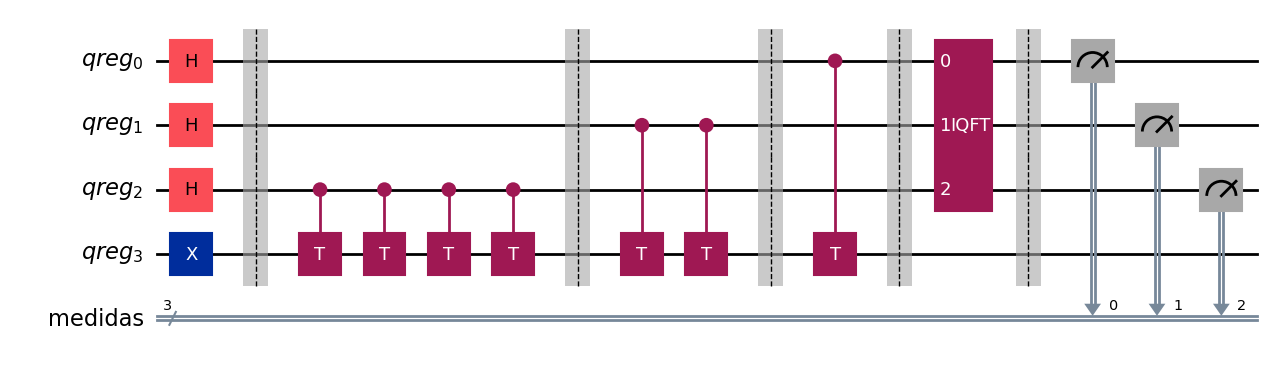

In [12]:
qc.barrier()

#Aplico la qft inversa a los m qubits menos significativos
qc = inverse_qft(m, qc)

qc.barrier()

#Medimos los m primeros qubits
qc.measure(qreg[0:m], creg[0:m])

display(qc.draw('mpl'))

Ahora ejecutaremos el circuito y obtendremos la medida en el registro contador auxiliar

Obten el histograma de medidas en numerico y visualizandolo en una figura

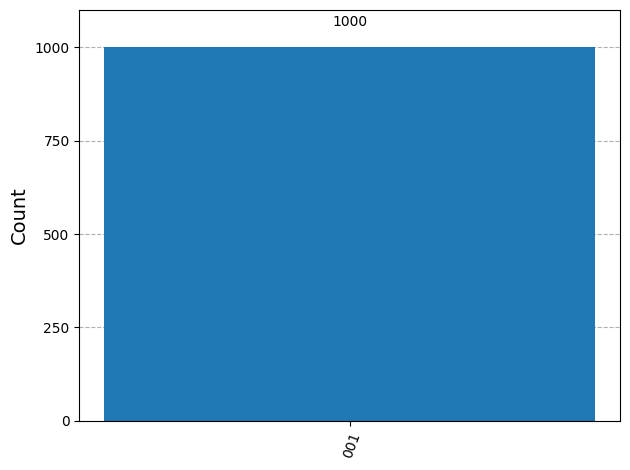

resultado -- cuenta
001      -- 1000


In [13]:
backend = Aer.get_backend('qasm_simulator')
tqc = transpile(qc, backend = backend, optimization_level= 1)
job = backend.run(tqc, shots = 1000)
result = job.result()
counts = result.get_counts()

#Tambien muestro el histograma
display(plot_histogram(counts))

count_to_digital_values(counts)


Vemos que debemos de obtener es (`001`) con total certeza, lo que se traduce al decimal: `1`. Ahora necesitamos dividir nuestro resultado (`1`) por $2^m$ para obtener el resultado exacto de $\theta$:

$$ \theta = \frac{1}{2^3} = \frac{1}{8} $$

En este caso, hemos obtenido el resultado exacto porque $2^{m}\theta$ es un numero entero.

--------------
#### Comentarios:
--------------

He creado una funcion llamada $apply\_CU\_gate(n, m, cu\_gate, qc)$ que tiene como parametro el numero de qubit $n$ de $\ket{\psi}$ el vector propio y luego $m$ que es el numero de qubits de medicion. También recibe una puerta U controlada que asumimos que ya viene construida con n qubits de objetivo y 1 qubit de control. La función me permite aplicar de manera general para cualquier n, m las sucesivas puertas $CU$ que me serviria más adelante si lo necesitase.

Luego, en vez de copiar y pegar las funciones de prácticas anteriores para construir la QFT y la IQFT, asumo como sabido la forma de implementarlo. Todo con el fin de tener un notebook más limpio y demasiadas funciones. He utilizado el constructor de la libreria de Qiskit.circuit para crearme una IQFT mediante $QFT(m, do_swaps = True, inverse=True)$ y lo agrego al circuito tal y como se ve en la función que he definido arriba

### EJERCICIO

En lugar de una puerta $T$, usemos otra puerta de un qubit, la puerta $P(\frac{2\pi}{3})$  de rotacion con un angulo $\theta = \frac{1}{3}= 0.333$. El vector propio de este operador que es |1>.

Crea el circuito y mide los resultados de estimacion de fase tomando $m=3$ como numero de qubits en el registro de conteo

En este caso $2^m \theta=2.666$ no es un numero entero, por lo que no vamos a poder medir con total certidumbre la fase.

In [17]:
from qiskit.circuit.library import CPhaseGate
#Importo de la libreria de qiskit la puerta de cambio de fase CPhaseGate

In [18]:
n = 1
m = 3

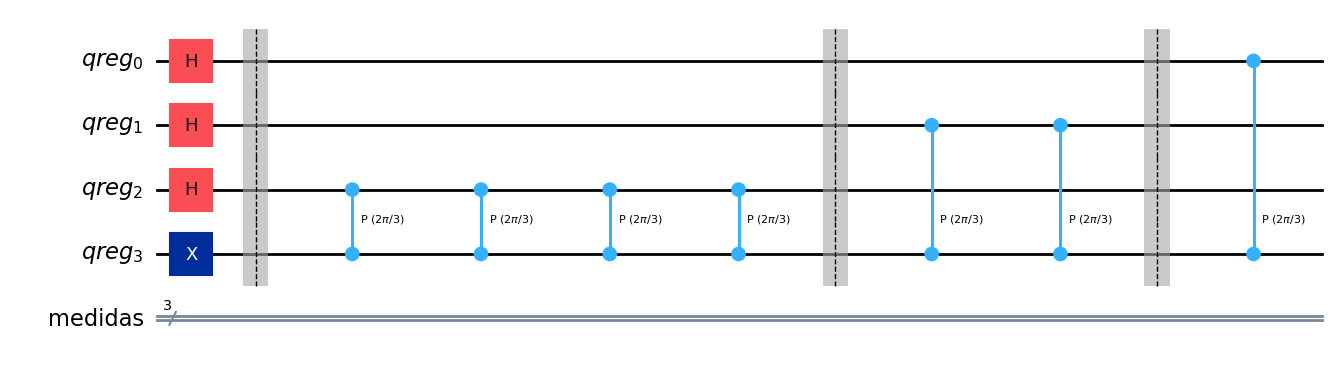

In [27]:
qreg = QuantumRegister(m + n, 'qreg')
creg = ClassicalRegister(m, 'medidas')

qc = QuantumCircuit(qreg, creg, name = 'QPE_CP')

#Aplico una puerta X al qubit n + m - 1
qc.x(qreg[n + m - 1])

#Pongo en superposicion los denas qubits de medida
qc.h(qreg[0:m])

#Creo un circuito que va a funcionar como la puerta controlada de fase
#Se que existe una funcion que me permite anyadir una puerta cp directamente
#Pero lo he creado igualmente para poder usar la funcion de apply_CU_gate() que he implementado mas arriba en el notebook
cp = CPhaseGate(2*math.pi/3) 

qc = apply_CU_gate(n, m, cp, qc)


display(qc.draw('mpl'))


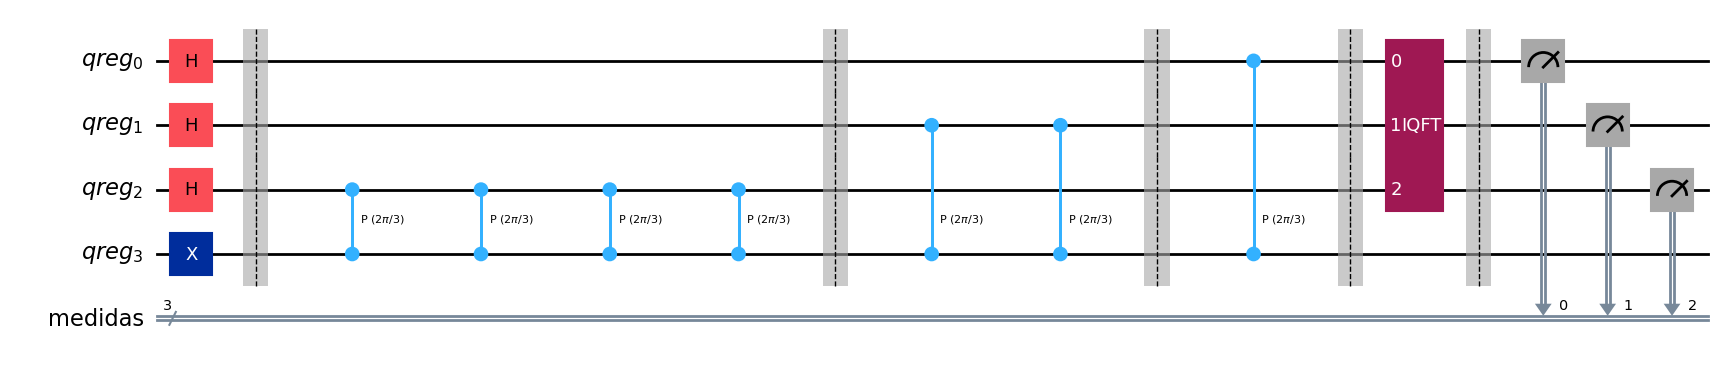

In [28]:
#Aqui aplico la qft inversa sobre los m qubits de medida
qc.barrier()
qc = inverse_qft(m, qc)
qc.barrier()


#Medimos los m primeros qubits
qc.measure(qreg[0:m], creg[0:m])

display(qc.draw('mpl'))

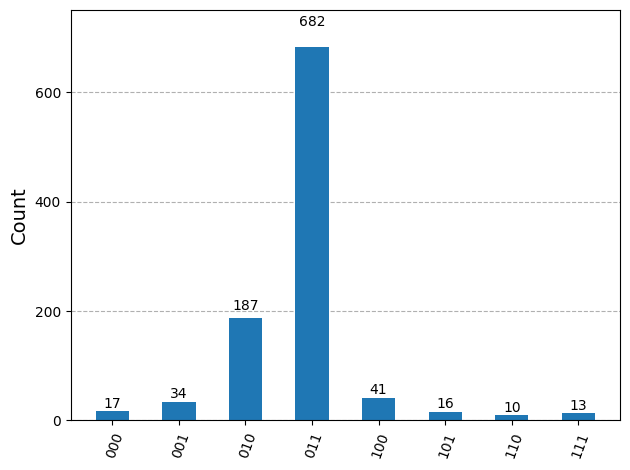

resultado -- cuenta
000      -- 17
001      -- 34
010      -- 187
011      -- 682
100      -- 41
101      -- 16
110      -- 10
111      -- 13


In [38]:
#Vamos a simular el circuito a ver que obtenemos
backend = Aer.get_backend('qasm_simulator')
tqc = transpile(qc, backend = backend, optimization_level= 1)
job = backend.run(tqc, shots = 1000)
result = job.result()
counts = result.get_counts()

#Tambien muestro el histograma
display(plot_histogram(counts))

count_to_digital_values(counts)

Estamos esperando el resultado $\theta = 0.3333\dots$, pero con este circuito tenemos que obtener que nuestros resultados más probables son `010(bin) = 2(dec)` y `011(bin) = 3(dec)`. Estos dos resultados nos dirían que $\theta = 0,25$ (desviación del 25%) y $\theta = 0,375$ (desviación del 13%) respectivamente. El verdadero valor de $\theta$ se encuentra entre los valores que podemos obtener de nuestros bits de conteo, y esto nos da incertidumbre e imprecisión.

--------------
#### Comentarios:
--------------

En el circuito que he implementado se puede observar una mayoria de las medidas en el valor de $\ket{011}$ y algo menos, pero igualmente alto, en $\ket{010}$.\

$2^m\theta = 2.6666$ en nuestro caso, entonces $\ket{010} = \ket{3}$ es el valor mas cercano y es por eso que sea el estado con mayor amplitud del state vector.

### EJERCICIO

Para obtener más precisión, simplemente agregamos más qubits de conteo. Vamos a agregar dos qubits de conteo más, tomando $m=5$

In [49]:
m = 5

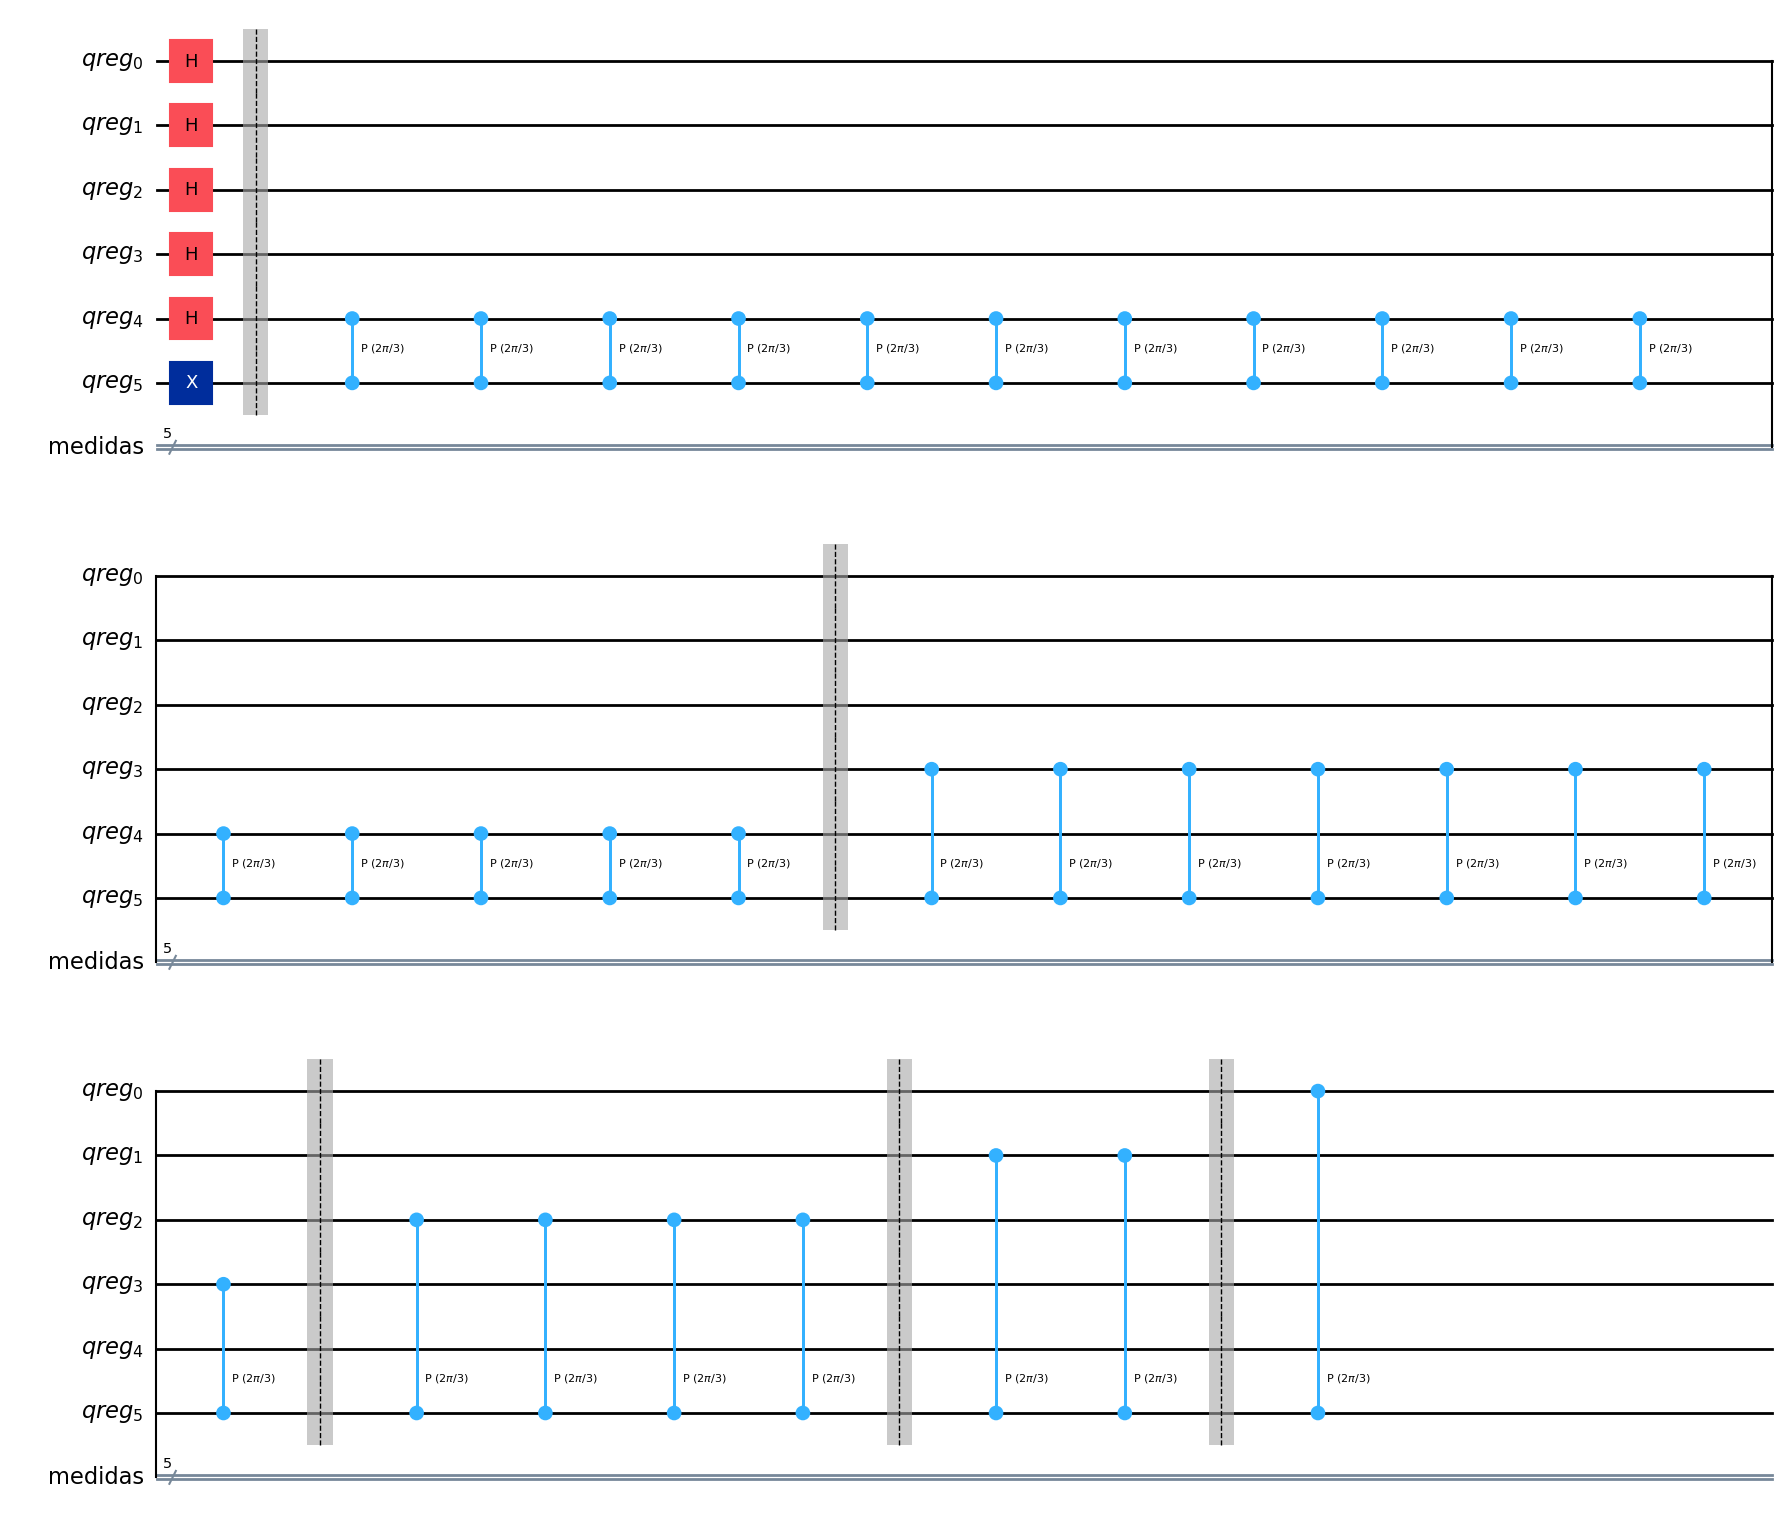

In [50]:
#Volvemos a implementar el circuito
qreg = QuantumRegister(m + n, 'qreg')
creg = ClassicalRegister(m, 'medidas')

qc = QuantumCircuit(qreg, creg, name = 'QPE_CP')

#Aplico una puerta X al qubit n + m - 1
qc.x(qreg[n + m - 1])

#Pongo en superposicion los denas qubits de medida
qc.h(qreg[0:m])

#Creo un circuito que va a funcionar como la puerta controlada de fase
#Se que existe una funcion que me permite anyadir una puerta cp directamente
#Pero lo he creado igualmente para poder usar la funcion de apply_CU_gate() que he implementado mas arriba en el notebook
cp = CPhaseGate(2*math.pi/3) 

qc = apply_CU_gate(n, m, cp, qc)


display(qc.draw('mpl'))

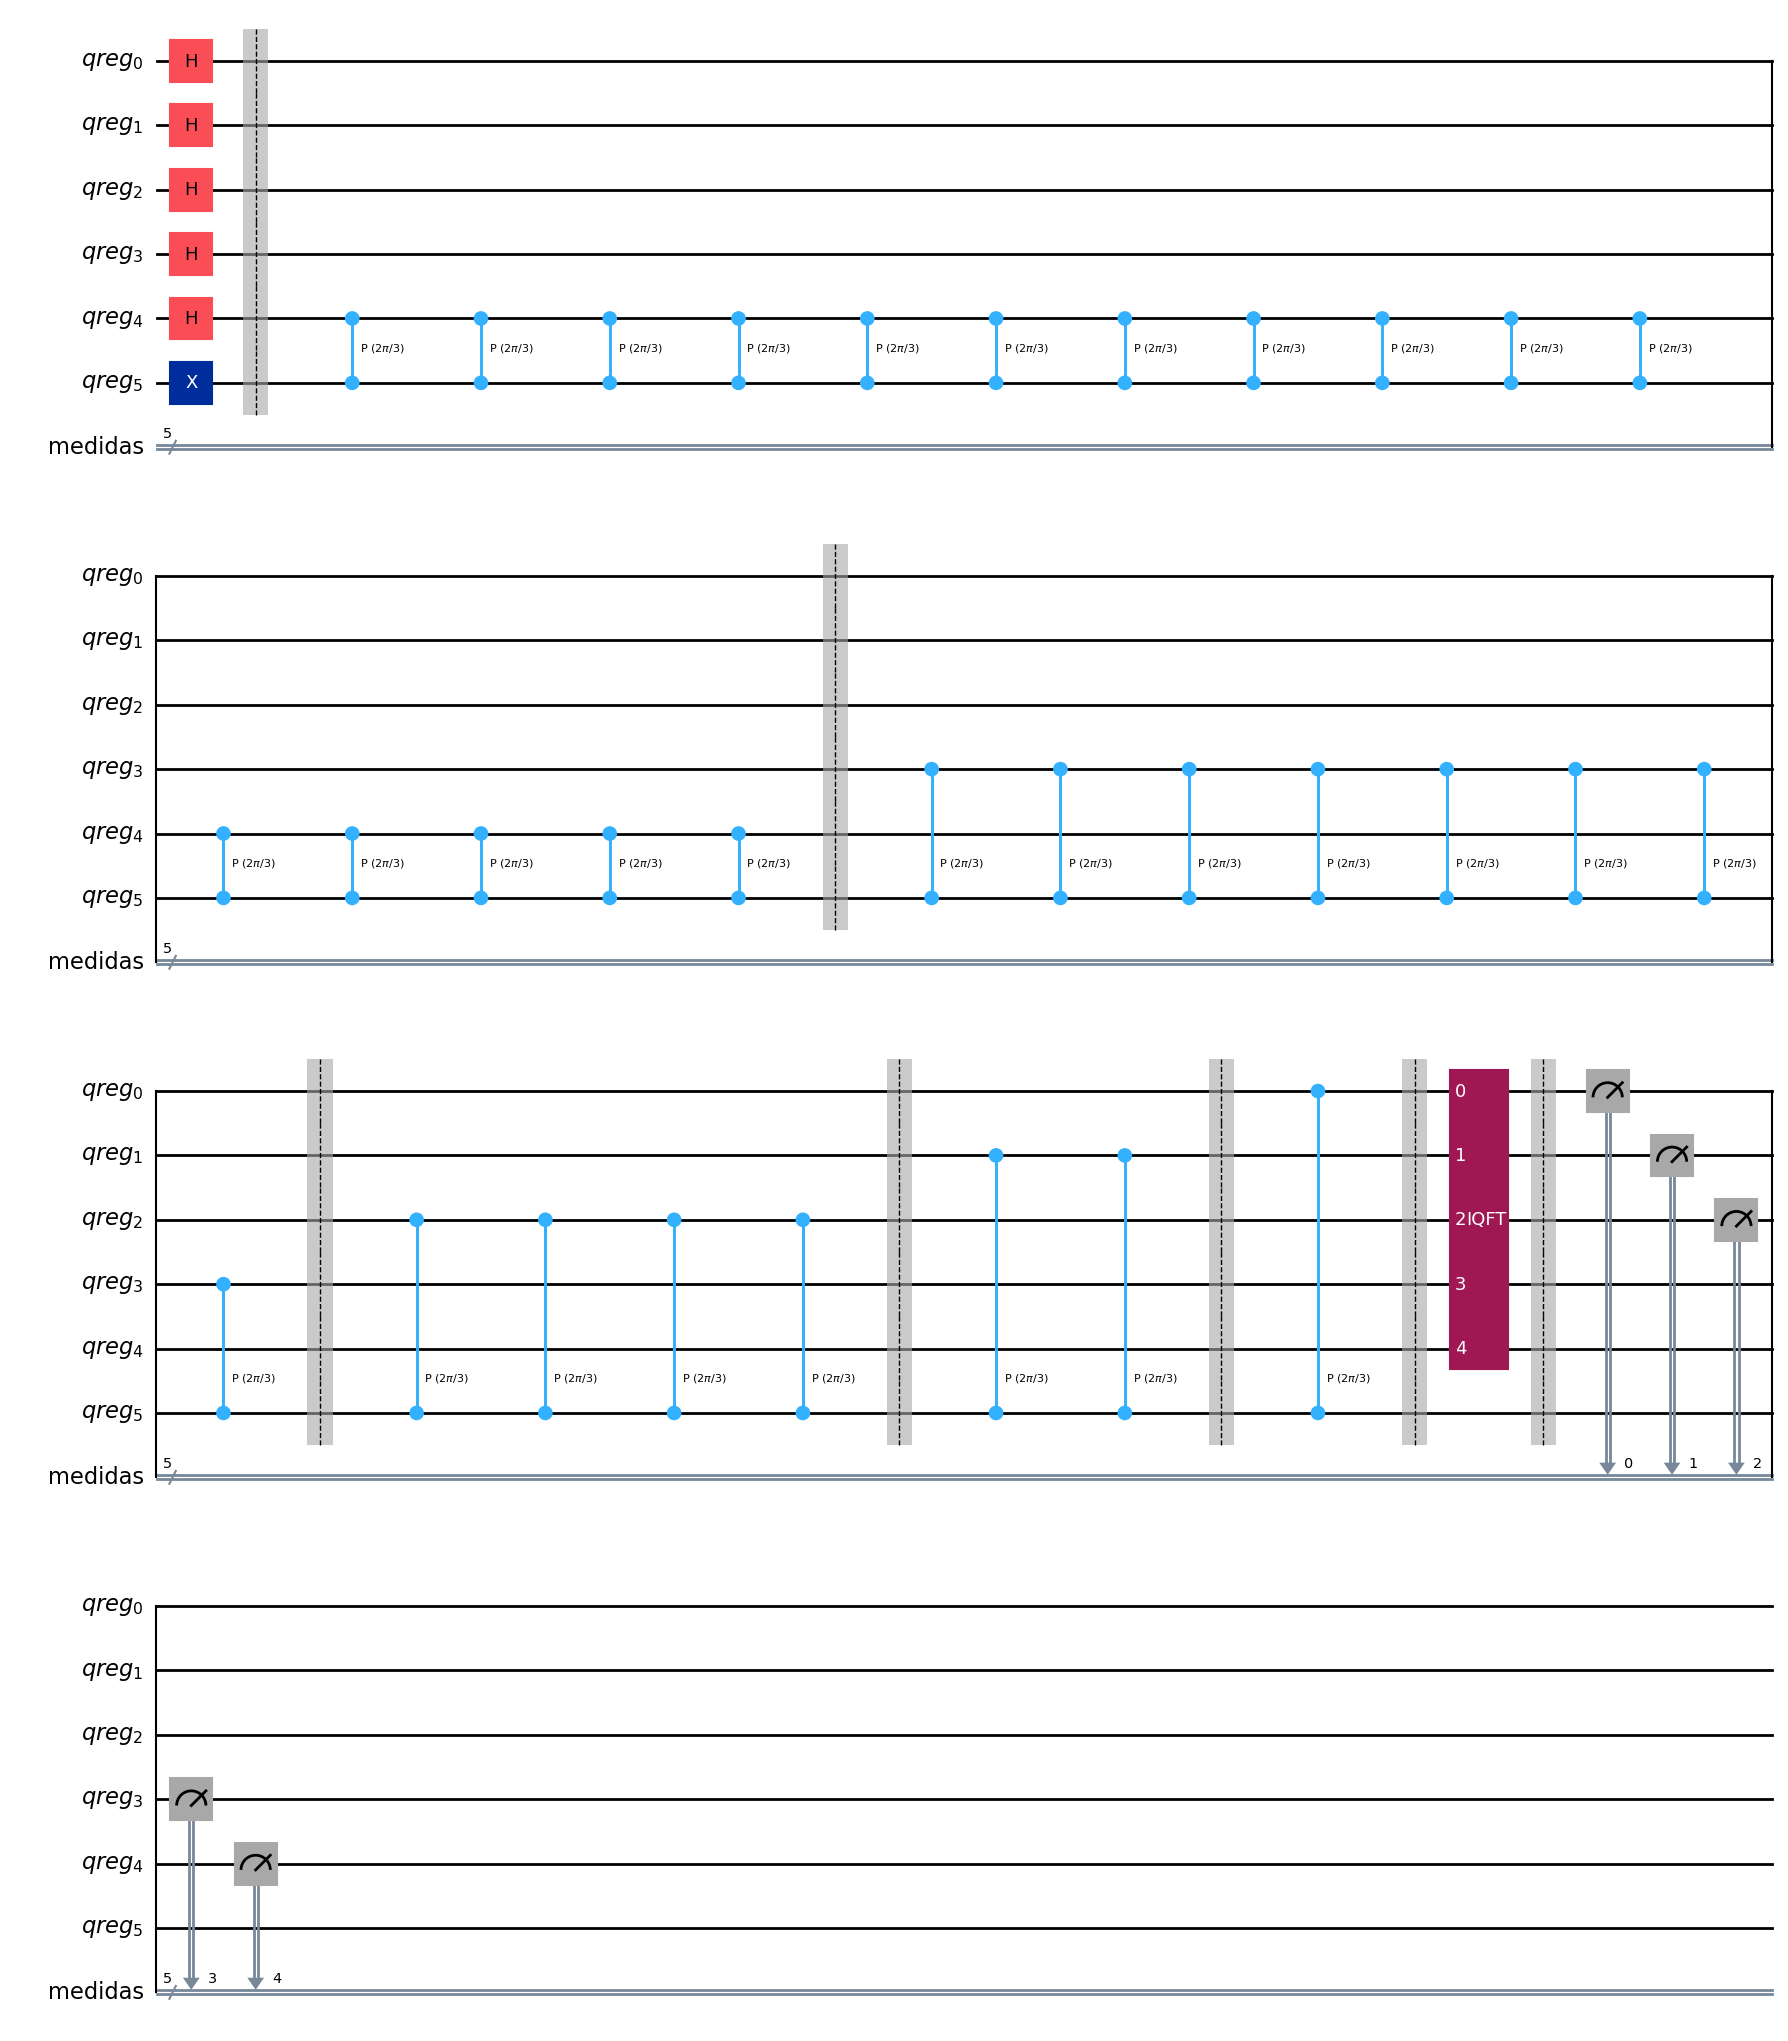

In [51]:
#Aqui aplico la qft inversa sobre los m qubits de medida
qc.barrier()
qc = inverse_qft(m, qc)
qc.barrier()


#Medimos los m primeros qubits
qc.measure(qreg[0:m], creg[0:m])

display(qc.draw('mpl'))

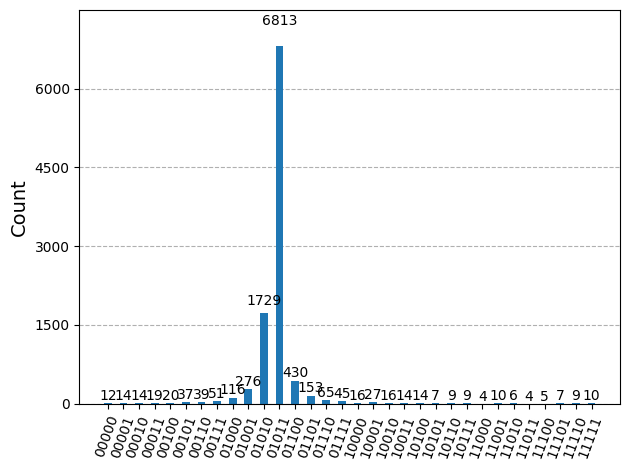

resultado -- cuenta
00000      -- 12
00001      -- 14
00010      -- 14
00011      -- 19
00100      -- 20
00101      -- 37
00110      -- 39
00111      -- 51
01000      -- 116
01001      -- 276
01010      -- 1729
01011      -- 6813
01100      -- 430
01101      -- 153
01110      -- 65
01111      -- 45
10000      -- 16
10001      -- 27
10010      -- 16
10011      -- 14
10100      -- 14
10101      -- 7
10110      -- 9
10111      -- 9
11000      -- 4
11001      -- 10
11010      -- 6
11011      -- 4
11100      -- 5
11101      -- 7
11110      -- 9
11111      -- 10


In [52]:
#Vamos a simular el circuito a ver que obtenemos
backend = Aer.get_backend('qasm_simulator')
tqc = transpile(qc, backend = backend, optimization_level= 1)
job = backend.run(tqc, shots = 10000)
result = job.result()
counts = result.get_counts()

#Tambien muestro el histograma
display(plot_histogram(counts))

count_to_digital_values(counts)

Las dos medidas más probables que debemos de obtener ahora son  "01011" (11 decimal) y "01010" (10 decimal). Medir estos resultados nos diría que $\theta$ es:

$$
\theta = \frac{11}{2^5} = 0.344,\;\text{ o }\;\; \theta = \frac{10}{2^5} = 0,313
$$

Estos dos resultados difieren de $\frac{1}{3}$ en un 3% y un 6% respectivamente. ¡Una precisión mucho mejor!

## Ejecución en un Simulador con ruido

### EJERCICIO

Ejecuta el circuito los ejercicios anteriores, donde estimamos la fase de los operadores $T$ y $P(\frac{2\pi}{3})$  en un simulador con ruido

In [53]:
#Importamos de la libreria fake_provider el backend que simula con ruido para los circuitos
from qiskit.providers.fake_provider import GenericBackendV2

Para este problema, voy a utilizar para el caso de $T$ una $m = 3$ y para $P$ con una $m = 5$ para obtener mayor precision

In [55]:
n = 1 

##### Caso QPE con $T$

In [54]:
m = 3

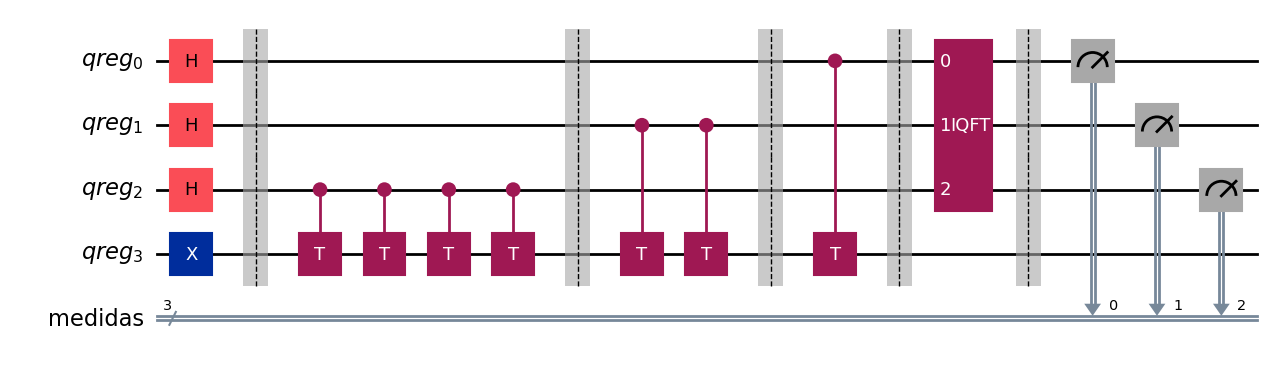

In [156]:
#qpe T \thta = 1

#Creo el circuito copiando el codigo de ejercicios anteriores
qreg = QuantumRegister(n + m, 'qreg')
creg = ClassicalRegister(m, 'medidas')

qc = QuantumCircuit(qreg, creg)


#Aplico una puerta X al qubit n + m - 1 que es el qubit que me servira de autovector o vector propio
qc.x(qreg[n + m - 1])

#Aplico la puerta H a todos los qubits de medida
qc.h(qreg[0:m])

#Ahora aplico aqui las puertas U controladas, donde U es la puerta T en este caso
ct = TGate().control(1)
qc = apply_CU_gate(n, m, ct, qc)

qc.barrier()

#Aplico la qft inversa a los m qubits menos significativos
qc = inverse_qft(m, qc)

qc.barrier()

#Medimos los m primeros qubits
qc.measure(qreg[0:m], creg[0:m])

display(qc.draw('mpl'))


En esta parte voy a simularlo con el simulador de GenericBackend2

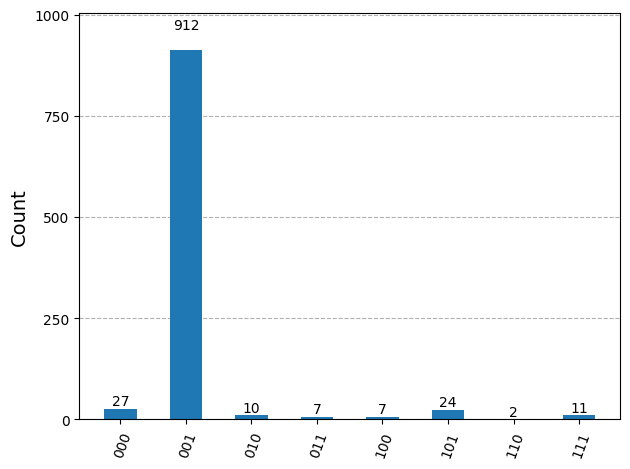

resultado -- cuenta
000      -- 27
001      -- 912
010      -- 10
011      -- 7
100      -- 7
101      -- 24
110      -- 2
111      -- 11


In [57]:
backend = GenericBackendV2(num_qubits = m + n)
tqc = transpile(qc, backend = backend, optimization_level = 1)
job = backend.run(tqc, shots = 1000)
result = job.result()
counts = result.get_counts()

display(plot_histogram(counts))
count_to_digital_values(counts)

Al realizar la simulacion con un backend con ruido, ya no obtenemos un 100% de las mediciones en $\ket{001}$, pero aún así vemos que la mayoria de las mediciones colapsan en ese estado.

##### Caso QPE con $P$

In [58]:
m = 5 

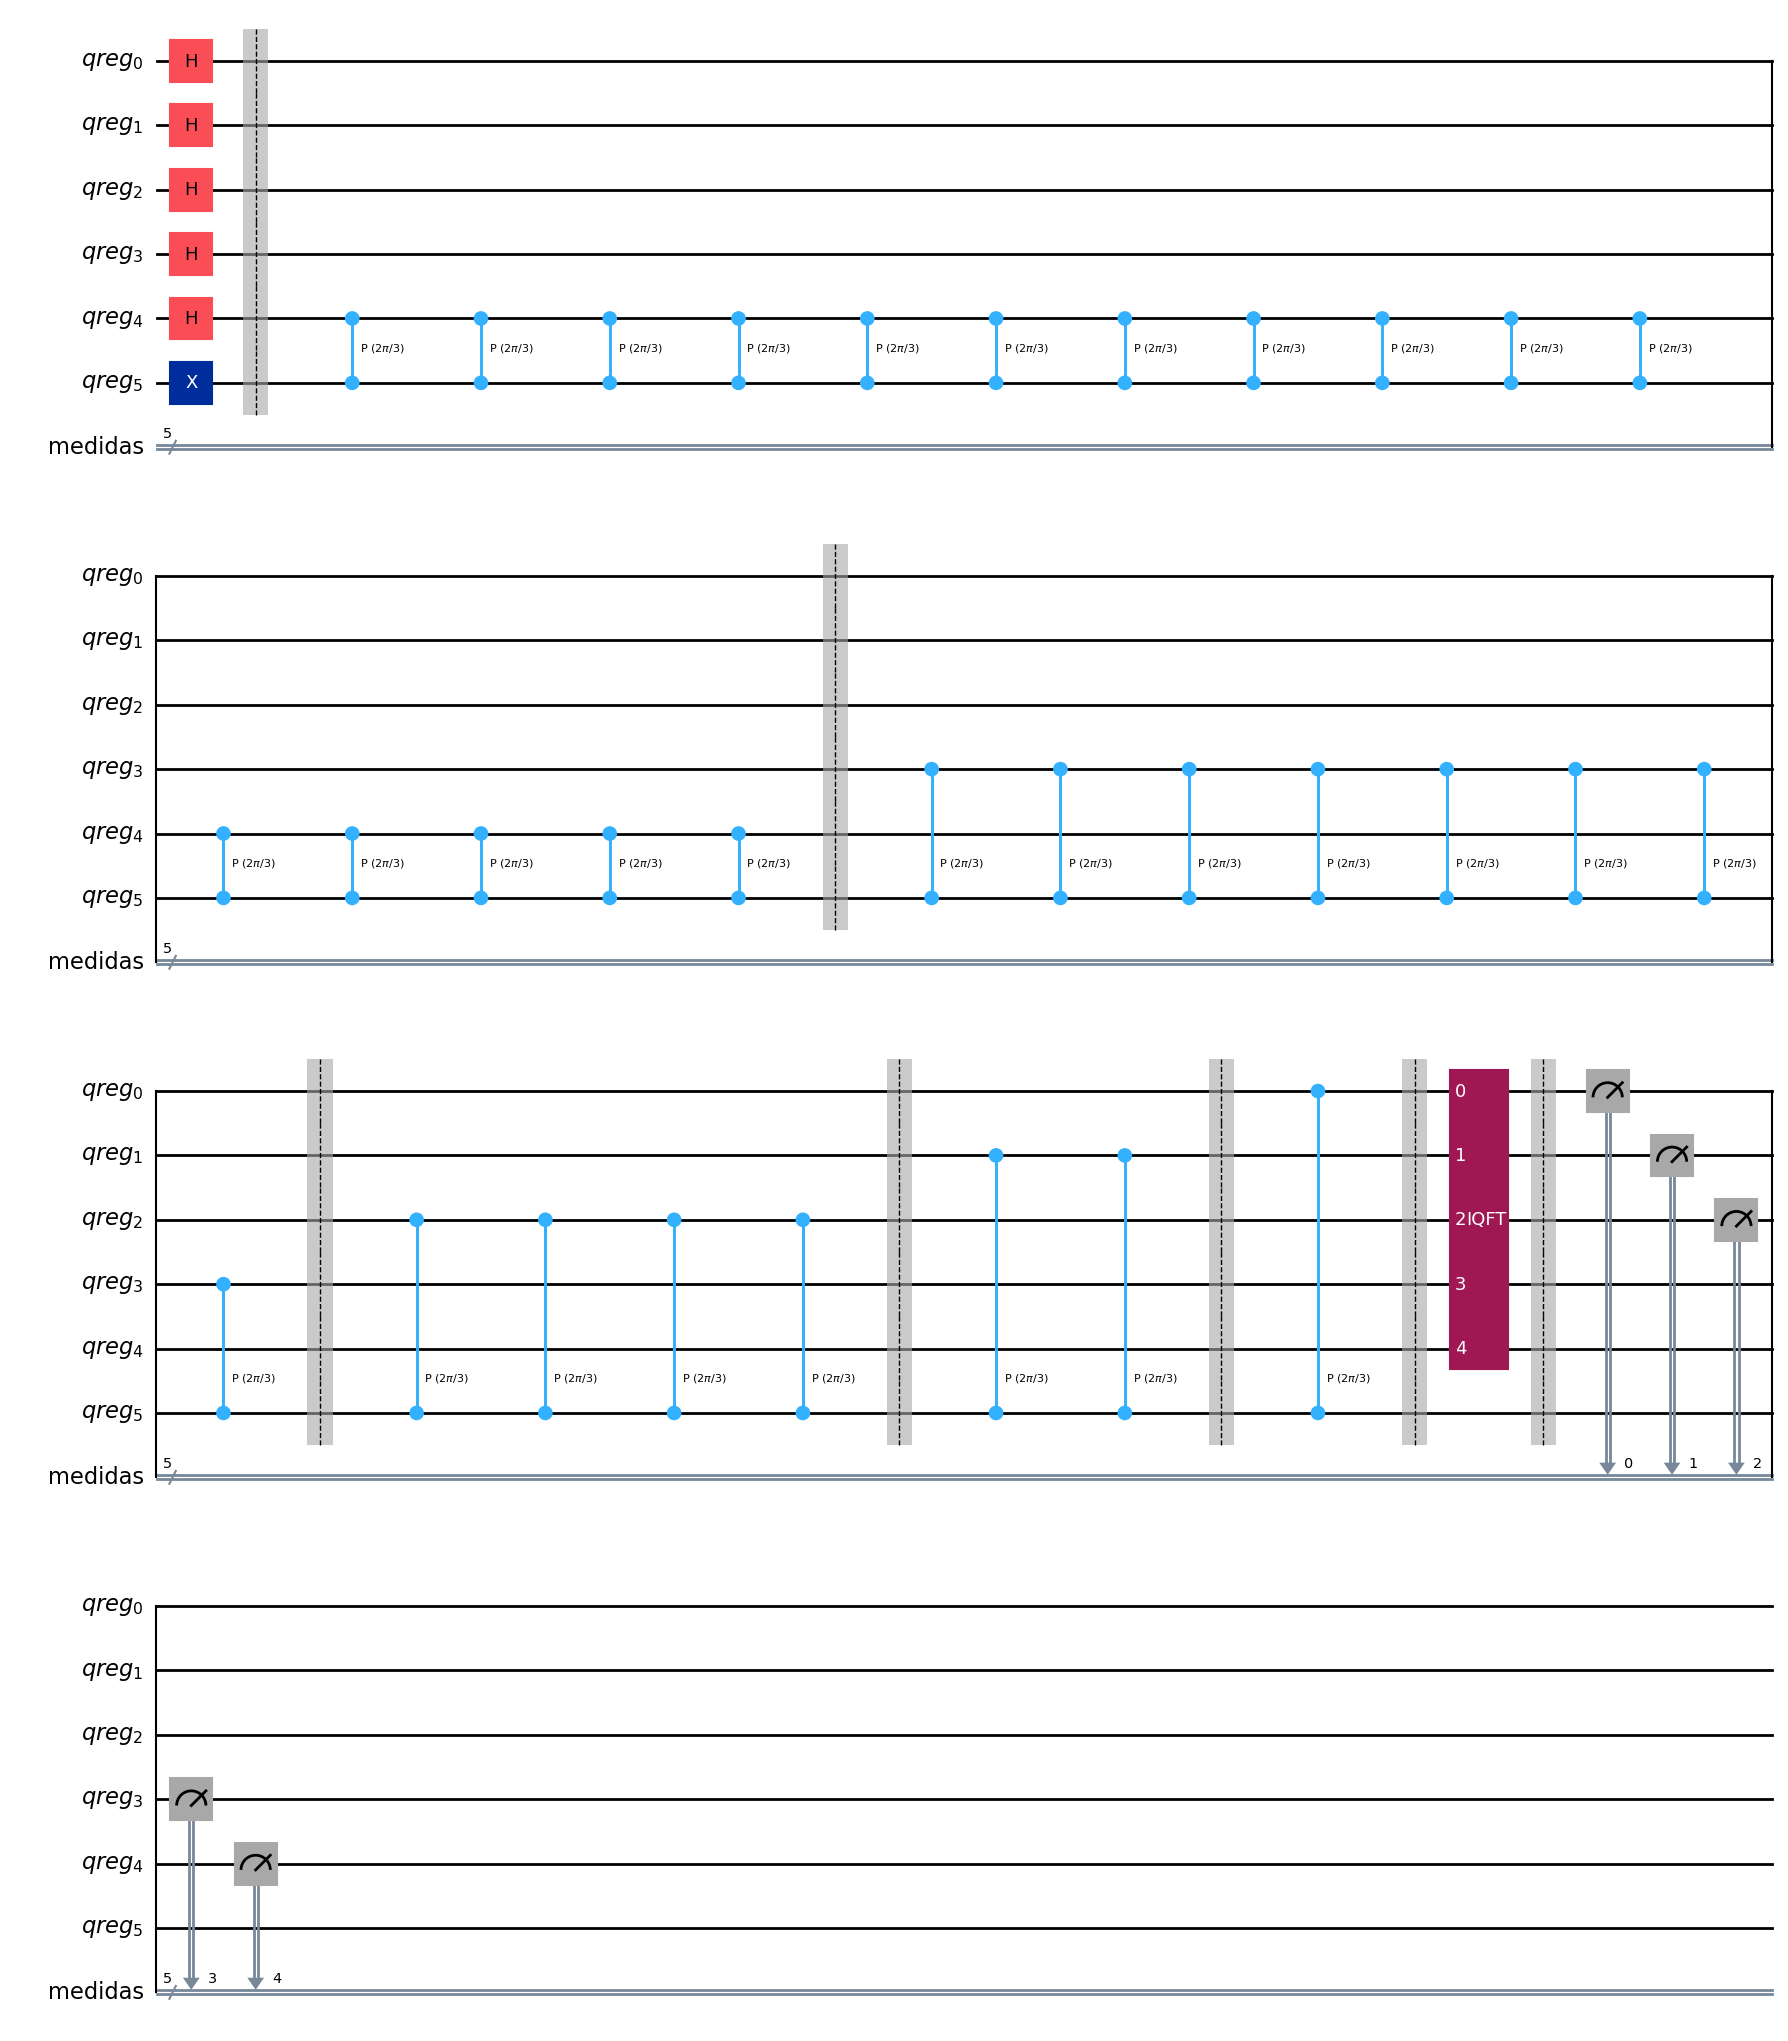

In [59]:
#qpe P \theta 1/3

#Creo el circuito copiando el codigo de ejercicios anteriores
qreg = QuantumRegister(n + m, 'qreg')
creg = ClassicalRegister(m, 'medidas')

qc = QuantumCircuit(qreg, creg)


#Aplico una puerta X al qubit n + m - 1 que es el qubit que me servira de autovector o vector propio
qc.x(qreg[n + m - 1])

#Aplico la puerta H a todos los qubits de medida
qc.h(qreg[0:m])

#Ahora aplico aqui las puertas U controladas, donde U es la puerta T en este caso
cp = CPhaseGate(2*math.pi/3)
qc = apply_CU_gate(n, m, cp, qc)

qc.barrier()

#Aplico la qft inversa a los m qubits menos significativos
qc = inverse_qft(m, qc)

qc.barrier()

#Medimos los m primeros qubits
qc.measure(qreg[0:m], creg[0:m])

display(qc.draw('mpl'))

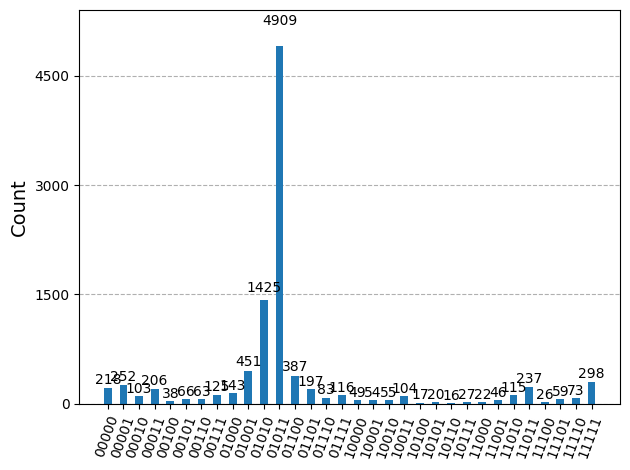

resultado -- cuenta
00000      -- 218
00001      -- 252
00010      -- 103
00011      -- 206
00100      -- 38
00101      -- 66
00110      -- 63
00111      -- 125
01000      -- 143
01001      -- 451
01010      -- 1425
01011      -- 4909
01100      -- 387
01101      -- 197
01110      -- 83
01111      -- 116
10000      -- 49
10001      -- 54
10010      -- 55
10011      -- 104
10100      -- 17
10101      -- 20
10110      -- 16
10111      -- 27
11000      -- 22
11001      -- 46
11010      -- 115
11011      -- 237
11100      -- 26
11101      -- 59
11110      -- 73
11111      -- 298


In [61]:
backend = GenericBackendV2(num_qubits = m + n)
tqc = transpile(qc, backend = backend, optimization_level = 1)
job = backend.run(tqc, shots = 10000)
result = job.result()
counts = result.get_counts()

display(plot_histogram(counts))
count_to_digital_values(counts)

Al añadir ruido a la simulacion vemos que hay se producen un poco más de mediciones en valores con desviaciones más grandes a $2.6666...$, pero aún así, los estados en los que colapsa mayoritariamente nuestro circuito es en $\ket{01011} = \ket{11}$ (este el que mas) y le sigue $\ket{01010} = \ket{10}$. 

Por tanto, podemos concluir que obtenemos los resultados esperados.

## Ejecucion en un BackEnd cuántico

### EJERCICIO

Ejecuta los circuitos anteriores en Backend cuántico real

In [67]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

token = "87d43698e0f0321e25277949171b3cded2957894f877e62e2b5f693e8779d8edf05ed78257c02f9acf8b05e3e52e4879a2c4ab7008363f5afcd7a01511e713c7" 

In [68]:
n = 1

##### Caso QPE con $T$

In [143]:
m = 3

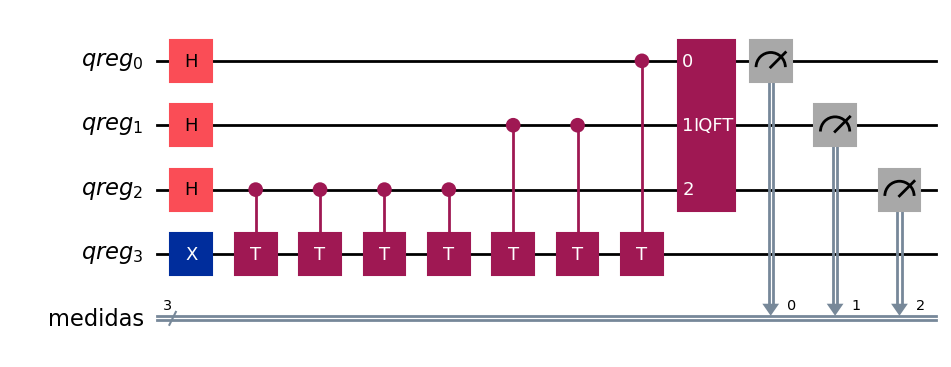

In [157]:
#qpe T \thta = 1

#Creo el circuito copiando el codigo de ejercicios anteriores
qreg = QuantumRegister(n + m, 'qreg')
creg = ClassicalRegister(m, 'medidas')

qc = QuantumCircuit(qreg, creg)


#Aplico una puerta X al qubit n + m - 1 que es el qubit que me servira de autovector o vector propio
qc.x(qreg[n + m - 1])

#Aplico la puerta H a todos los qubits de medida
qc.h(qreg[0:m])

#Ahora aplico aqui las puertas U controladas, donde U es la puerta T en este caso
ct = TGate().control(1)
qc = apply_CU_gate(n, m, ct, qc, barrier = False)


#Aplico la qft inversa a los m qubits menos significativos
qc = inverse_qft(m, qc)


#Medimos los m primeros qubits
qc.measure(qreg[0:m], creg[0:m])

display(qc.draw('mpl'))

A continuacion seleccionamos una backend de IBM Quantum Platform para ejecutar el circuito. Pero antes de nada se transpila el circuito para ajustarlo a la topología del computador seleccionado

<IBMBackend('ibm_sherbrooke')>


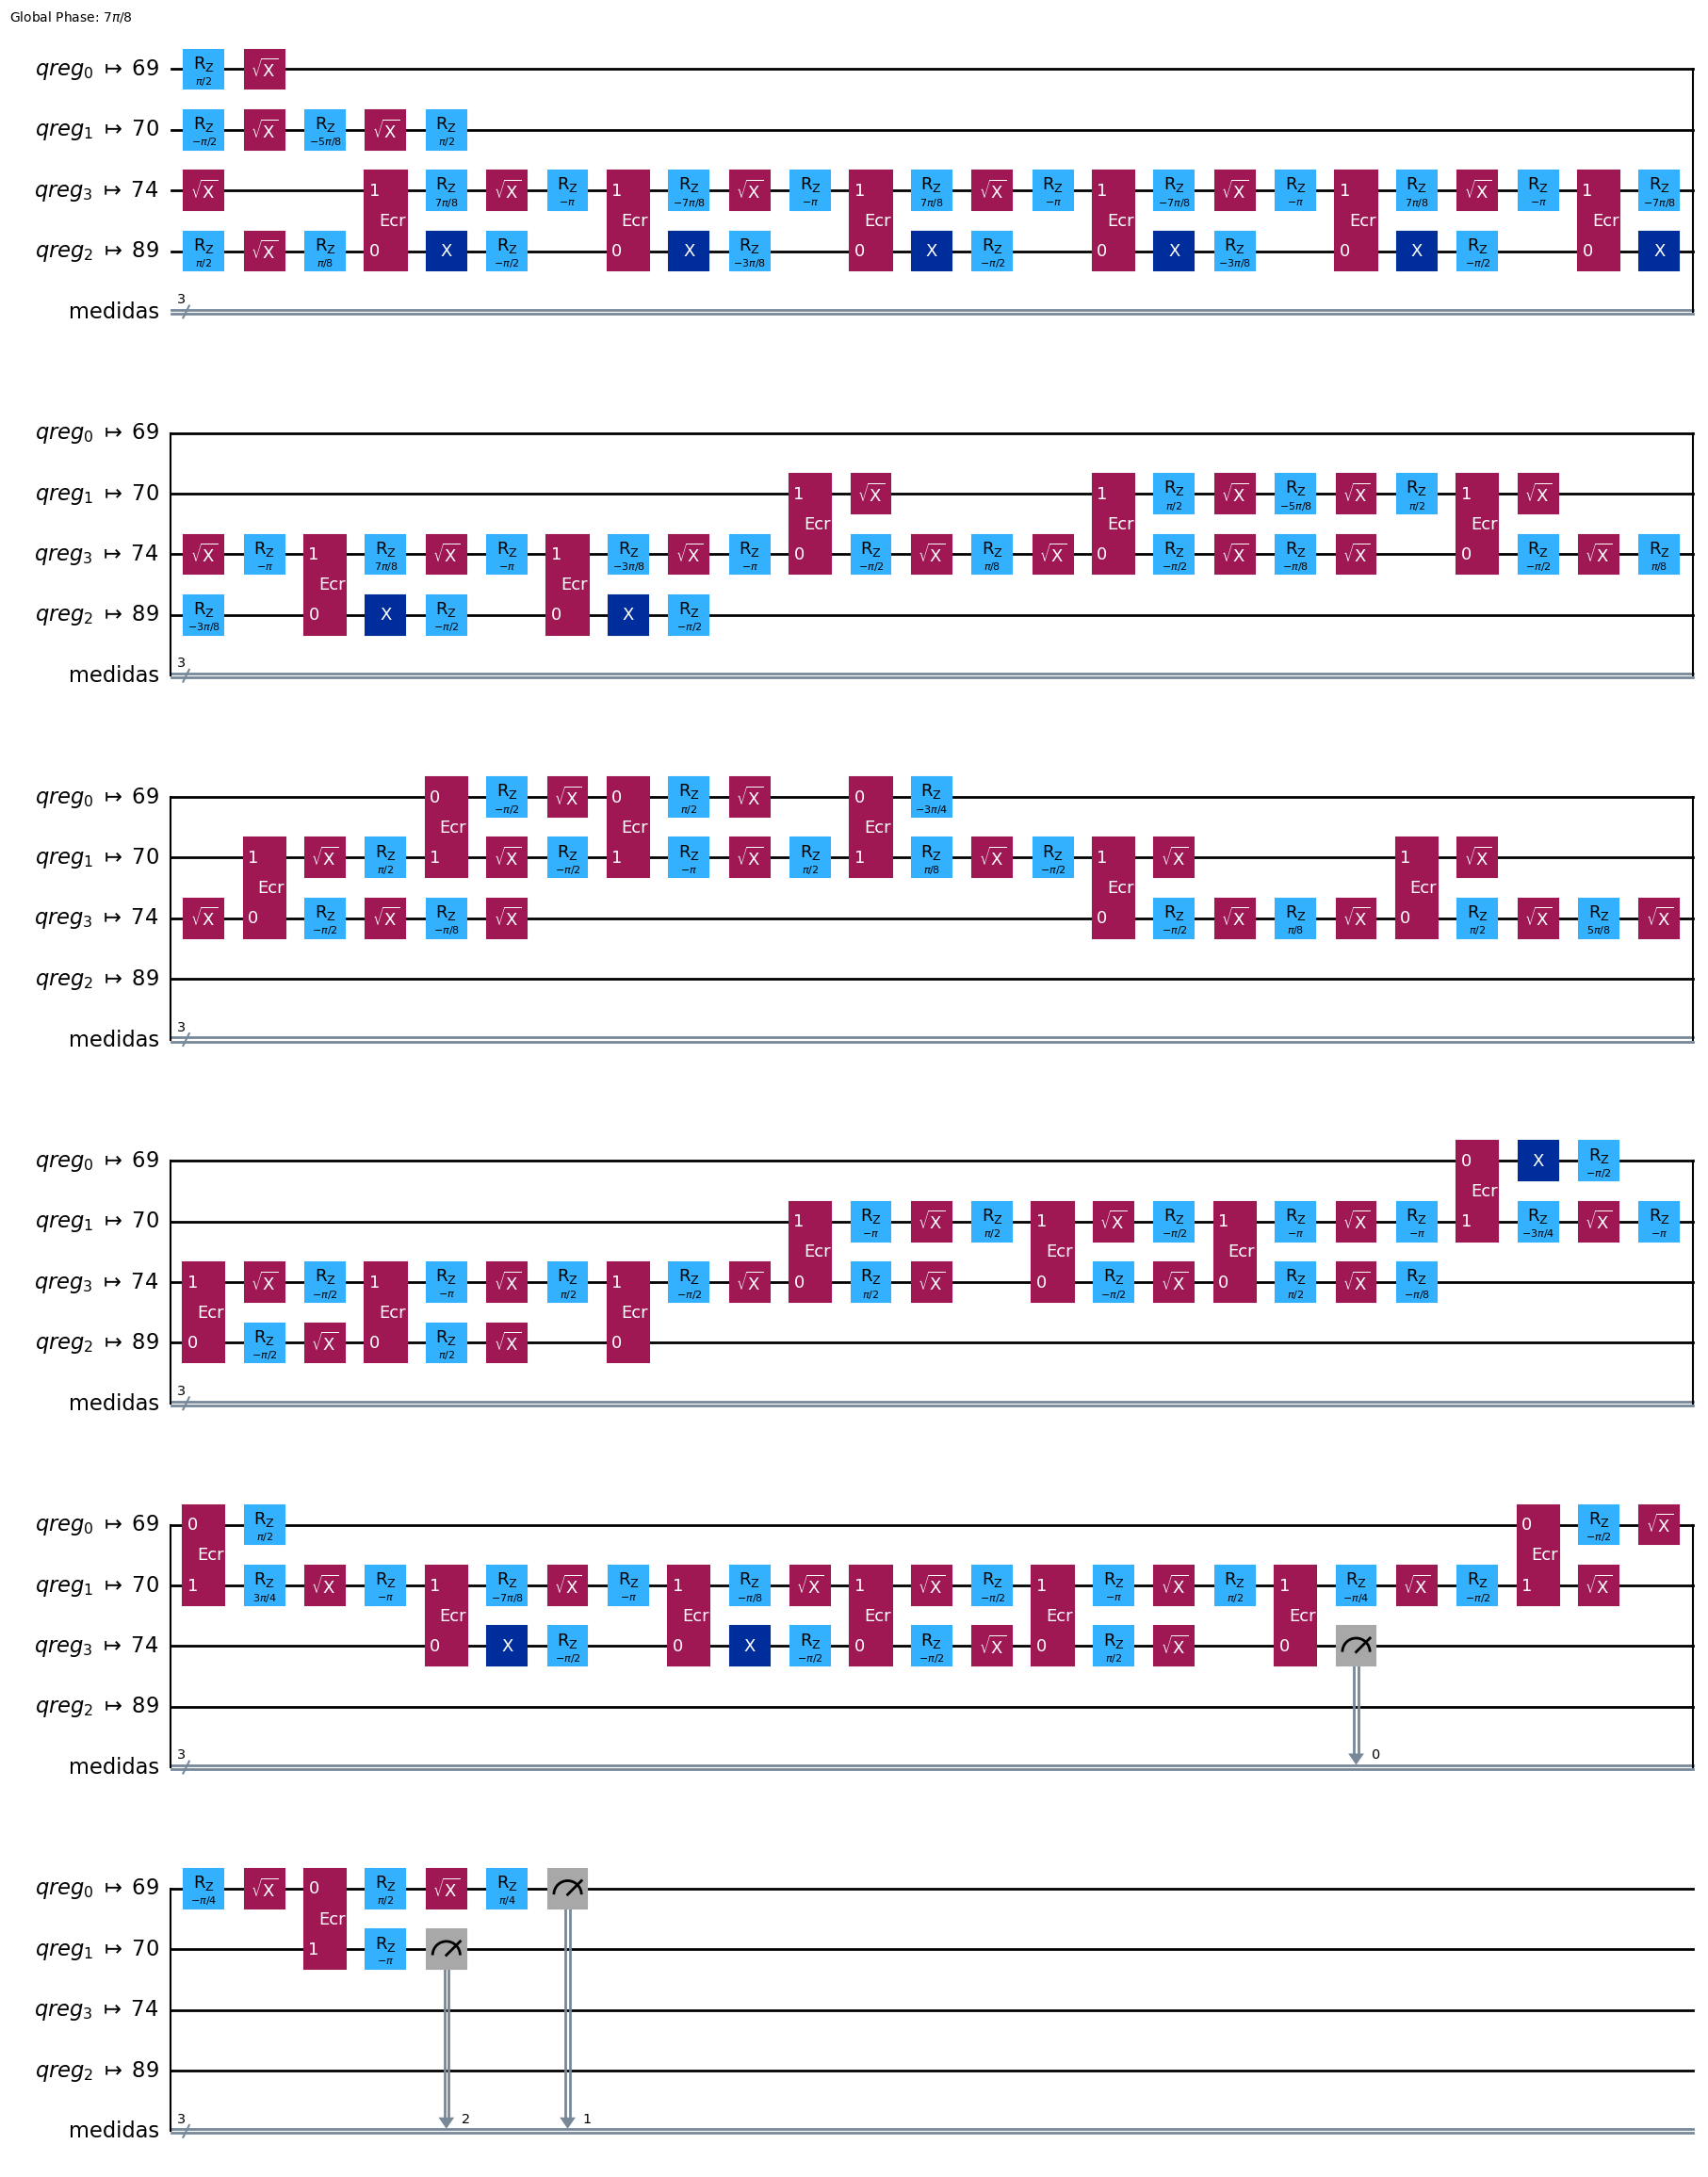

In [158]:
service = QiskitRuntimeService(channel="ibm_quantum", token=token)
#backend = service.least_busy(simulator=False, operational=True)
backend = service.backend("ibm_sherbrooke")
#backend = service.backend("ibm_kyiv")
print(backend)

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

#Mostramos el circuito compilado al computador cuántico real
isa_circuit.draw("mpl", idle_wires=False)

In [159]:
sampler = Sampler(backend)
job = sampler.run([isa_circuit], shots=1000)
print(f"job id: {job.job_id()}")
result = job.result()

job id: czz2fjy6rr3g008mjzk0


{'110': 91, '011': 52, '001': 369, '100': 28, '000': 176, '010': 118, '111': 69, '101': 97}


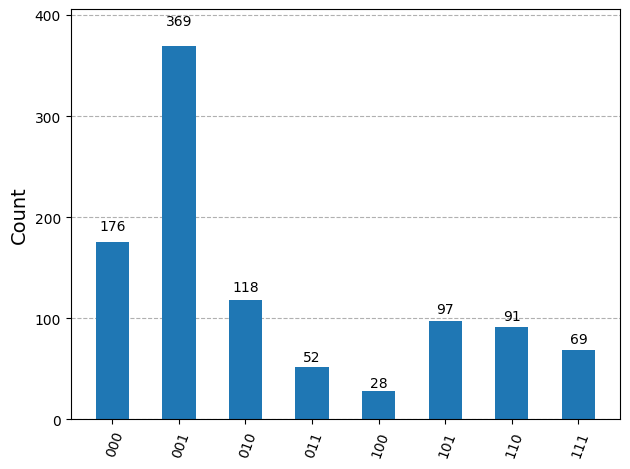

In [161]:
#Mostramos los resultados
for item in result._pub_results[0].data.items():
    print(item[1].get_counts())
    display(plot_histogram(item[1].get_counts()))

Tras muchas ejecuciones, por fin he logrado un gráfica medianamente decente. Como se puede ver, la medida mayoritaria es la de $\ket{001}$ como en las simulaciones del circuito.

He utilizado el computador de $ibm\_sherbrooke$ pues es el que menos ruido tenía registrado en IBM Quantum Platform. Aun así vemos que los errores, pese a no superar lo que buscamos, siguen siendo bastante grandes.

##### Caso QPE con $P$

In [177]:
m = 3

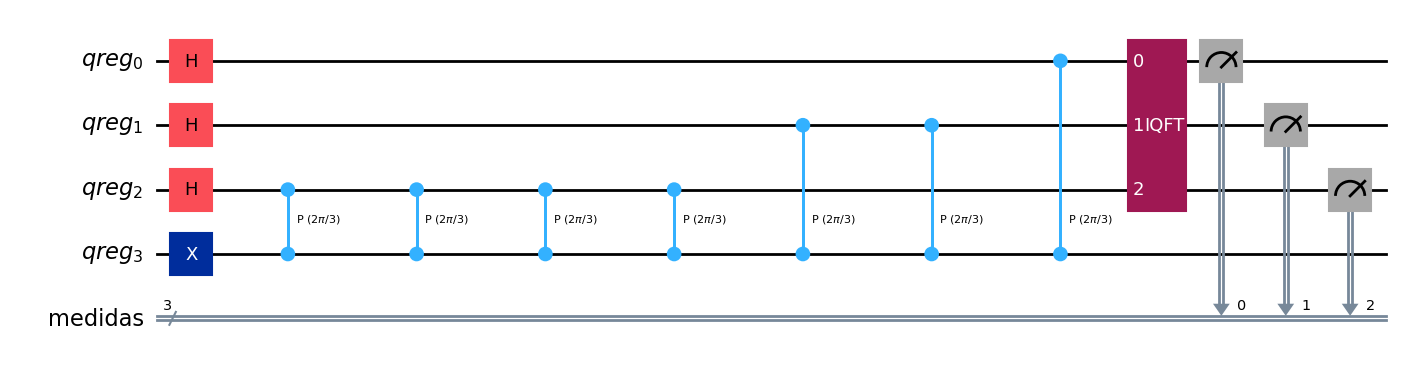

In [178]:
#qpe P \theta 1/3

#Creo el circuito copiando el codigo de ejercicios anteriores
qreg = QuantumRegister(n + m, 'qreg')
creg = ClassicalRegister(m, 'medidas')

qc = QuantumCircuit(qreg, creg)


#Aplico una puerta X al qubit n + m - 1 que es el qubit que me servira de autovector o vector propio
qc.x(qreg[n + m - 1])

#Aplico la puerta H a todos los qubits de medida
qc.h(qreg[0:m])

#Ahora aplico aqui las puertas U controladas, donde U es la puerta T en este caso
cp = CPhaseGate(2*math.pi/3)
qc = apply_CU_gate(n, m, cp, qc, barrier = False)


#Aplico la qft inversa a los m qubits menos significativos
qc = inverse_qft(m, qc)


#Medimos los m primeros qubits
qc.measure(qreg[0:m], creg[0:m])

display(qc.draw('mpl'))

<IBMBackend('ibm_sherbrooke')>


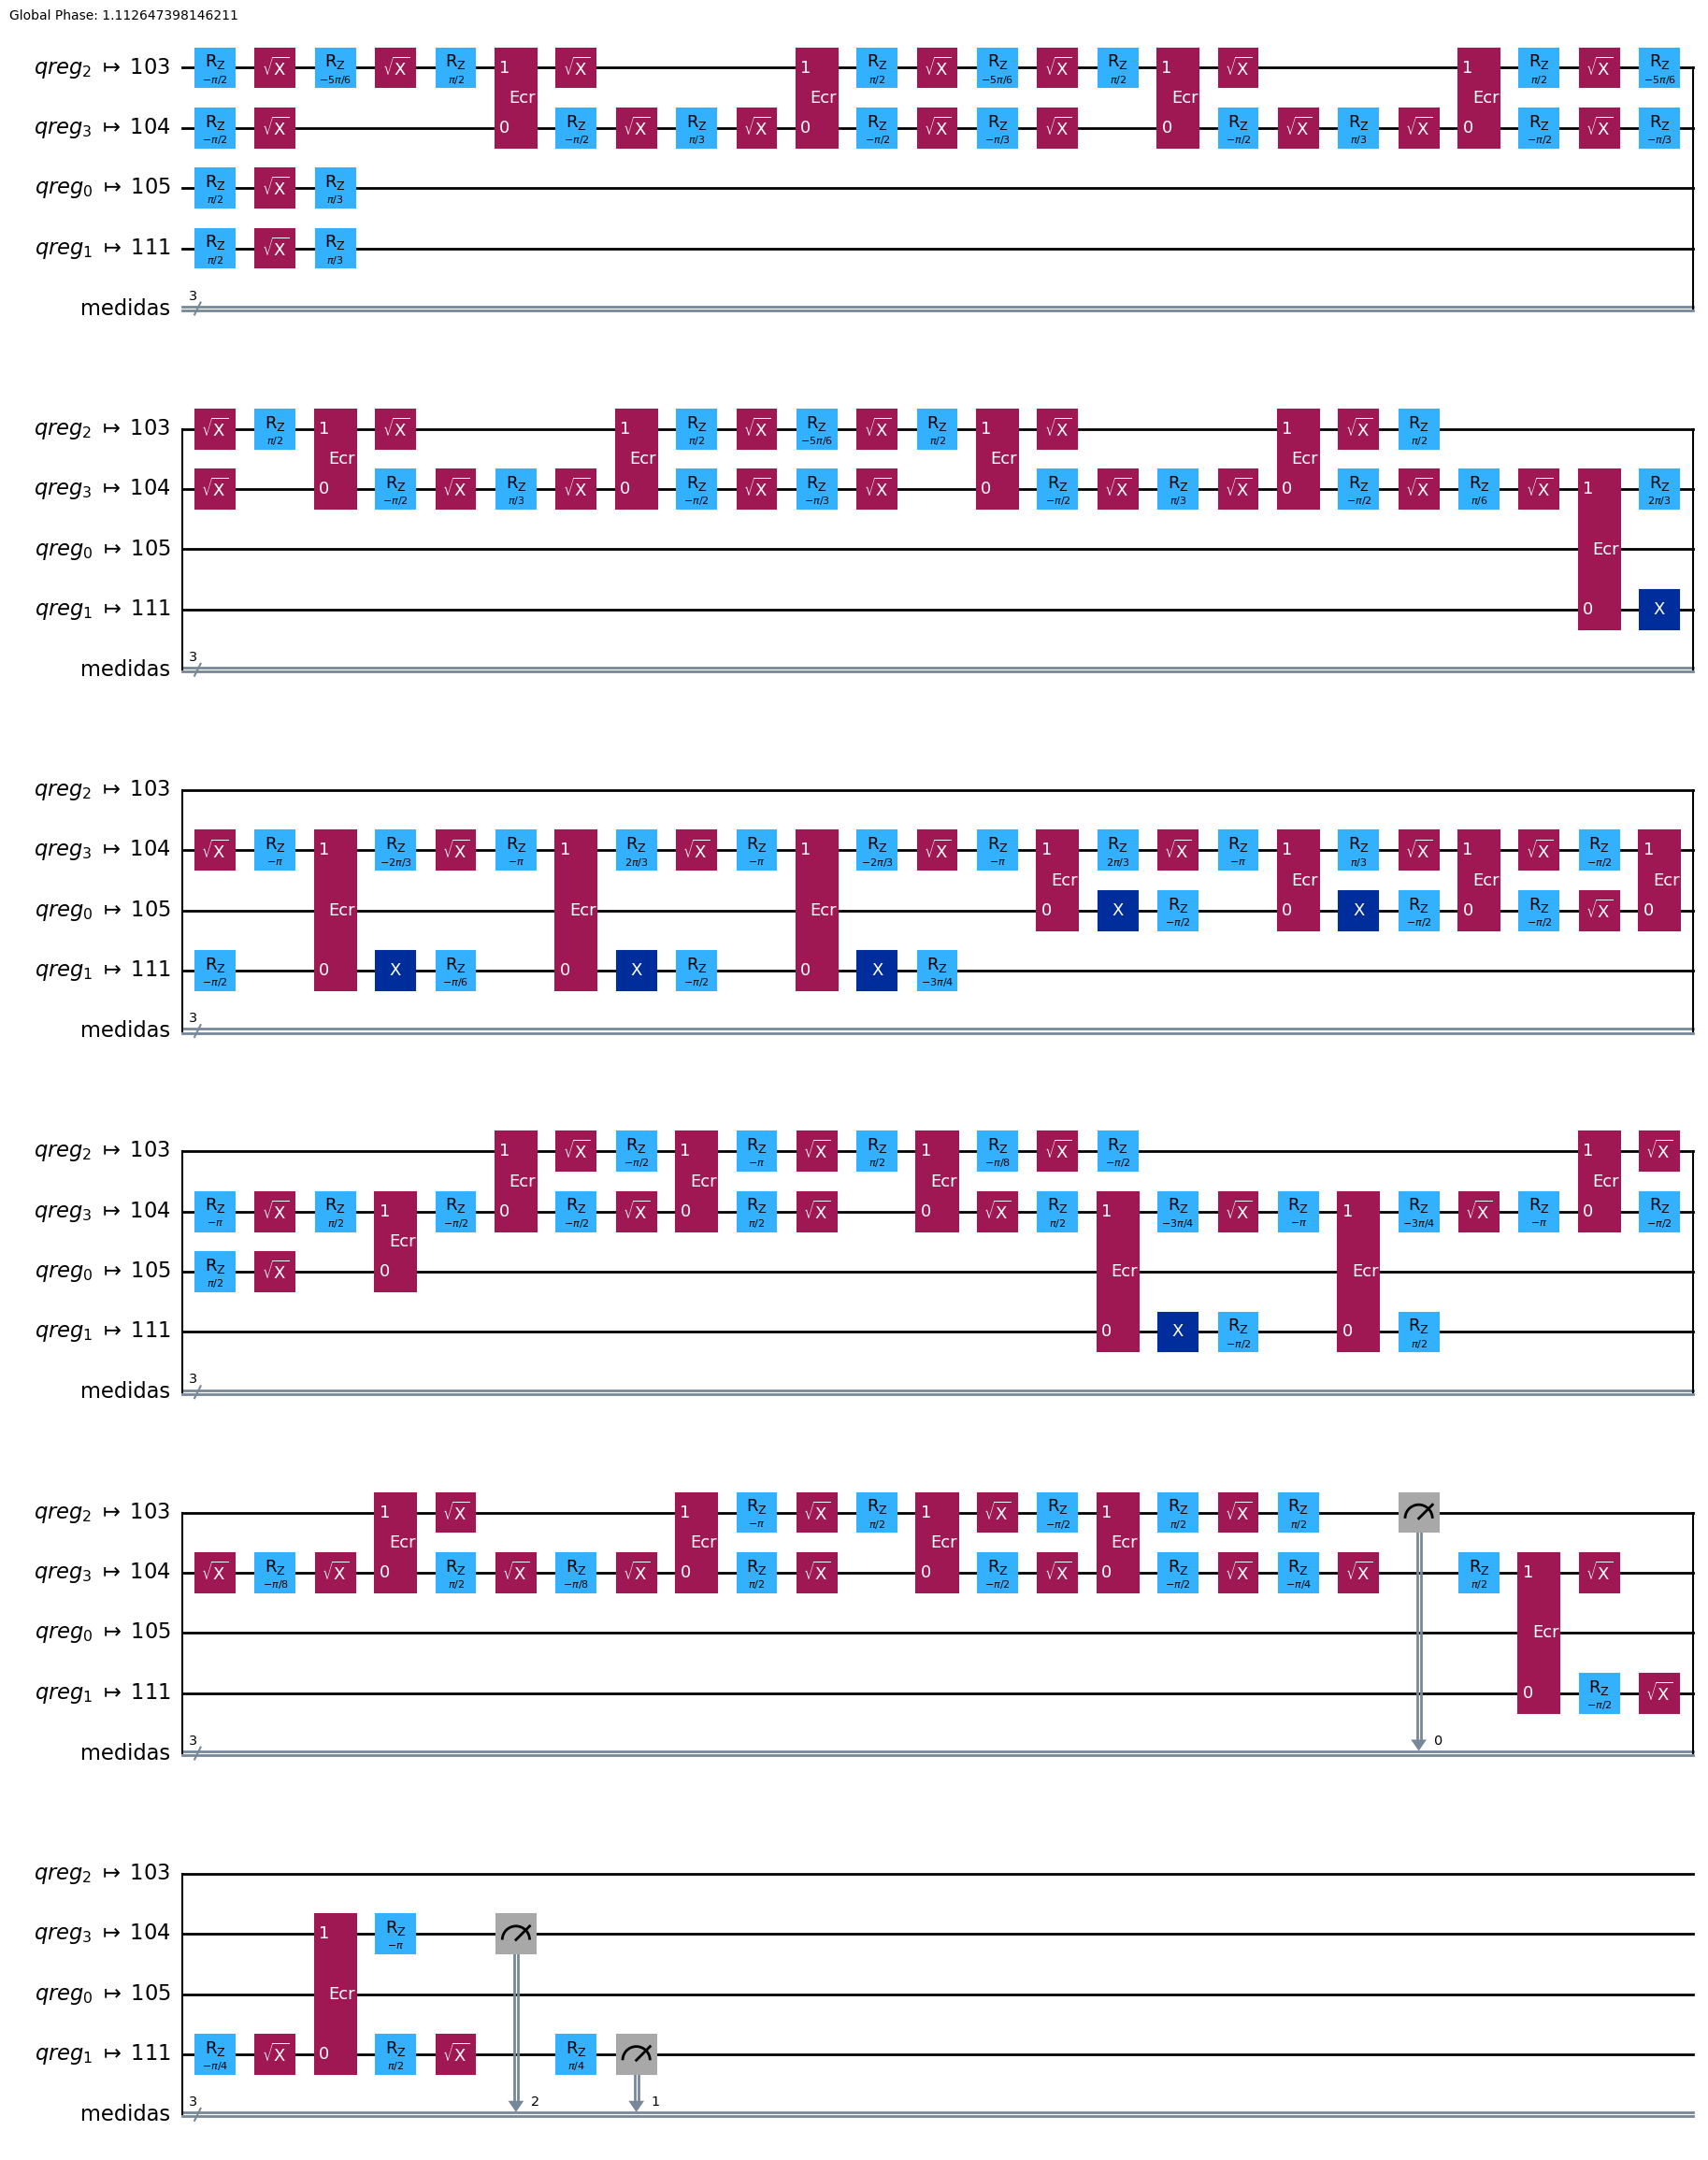

In [197]:
service = QiskitRuntimeService(channel="ibm_quantum", token=token)
#backend = service.least_busy(simulator=False, operational=True)
backend = service.backend("ibm_sherbrooke")
#backend = service.backend("ibm_kyiv")
print(backend)

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

#Mostramos el circuito compilado al computador cuántico real
isa_circuit.draw("mpl", idle_wires=False)

In [198]:
sampler = Sampler(backend)
job = sampler.run([isa_circuit], shots=1000)
print(f"job id: {job.job_id()}")
result = job.result()

job id: czz30816rr3g008mk640


{'001': 134, '100': 14, '101': 122, '000': 25, '110': 37, '011': 404, '010': 219, '111': 45}


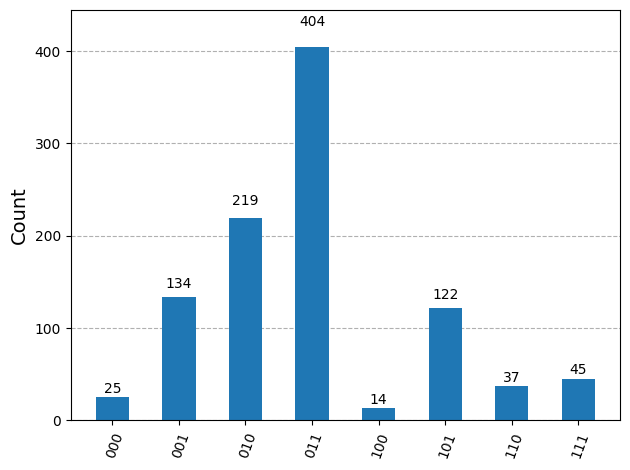

In [199]:
#Mostramos los resultados
for item in result._pub_results[0].data.items():
    print(item[1].get_counts())
    display(plot_histogram(item[1].get_counts()))

En este caso he probado a ejecutarlo en backend real con 3 qubits de medición.

La razón es porque he probado a ejecutarlo con 5 qubits, pero el circuito que obtengo tras el transpilado es sumamente grande y tras realizar numerosas ejecuciones, los errores que he ido obteniendo han sido demasiados. No he conseguido en ningún momento un gráfico cercano a lo que esperamos, que es, una mayoría de las mediciones en $\ket{11_{10}}$ seguido de $\ket{10_{10}}$ (en base decimal), teniendo en cuenta errores. No obstante, solo he obtenido gráficos muy heterogéneos sin ningún indicio claro de que la mayoría esté en los estado antes mencionados. Es más, la mayoría de las veces para los estados $\ket{11}$ y $\ket{10}$ son los que menos se miden.

Por lo tanto, para evitar que se acumule tanto ruido debido al tamaño del circuito, he decidido en bajar los qubits de medida a $m = 3$.\
Así, tras numerosas ejecuciones, también, obtengo el gráfico que se ve. Con un ruido que sigue siendo considerable, obtengo una mayoría de mediciones que colapsan en $\ket{3}$ y en $\ket{2}$, que al final es lo que esperamos obtener. Son los valores más cercanos a $2^{m}\theta = 2.6666\dots$